Installing required libraries 

In [22]:
!pip install torch torchvision seaborn matplotlib torchinfo opencv-python scikit-learn ultralytics


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Device setup

In [23]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


Emotion labels

In [24]:
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
label_map = {emotion: idx for idx, emotion in enumerate(emotions)}
inv_label_map = {v: k for k, v in label_map.items()}


Data transformation

In [25]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

Loading facial emotion recognition dataset

In [26]:
import os
from PIL import Image

def load_dataset(folder):
    images = []
    labels = []

    for emotion in emotions:
        emotion_path = os.path.join(folder, emotion)
        emotion_label = label_map[emotion]

        for fname in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, fname)

            img = Image.open(img_path).convert("L")
            img = transform(img)

            images.append(img)
            labels.append(emotion_label)

    return images, labels

In [27]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

data_root = r"C:\Users\munchkin\Downloads\Computer Vision\Group1\fer2013"

train_images, train_labels = load_dataset(os.path.join(data_root, "train"))
test_images, test_labels   = load_dataset(os.path.join(data_root, "test"))

train_images_tensor = torch.stack(train_images)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

test_images_tensor = torch.stack(test_images)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset  = TensorDataset(test_images_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128)

print("Train size:", len(train_dataset))
print("Test size :", len(test_dataset))


Train size: 28709
Test size : 7178


Train data distribution

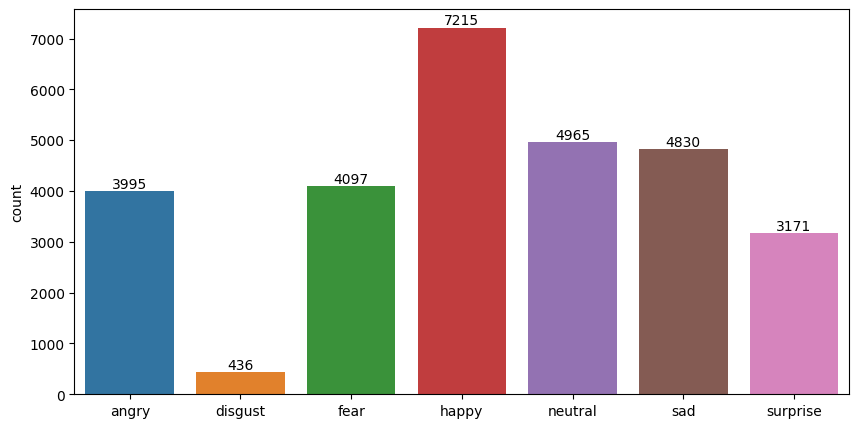

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

train_label_names = [inv_label_map[l] for l in train_labels]

plt.figure(figsize=(10, 5))
ax = sns.countplot(
    x=train_label_names,
    hue=train_label_names,
    palette="tab10"
)

for container in ax.containers:
    ax.bar_label(container)

plt.show()


Test data distribution

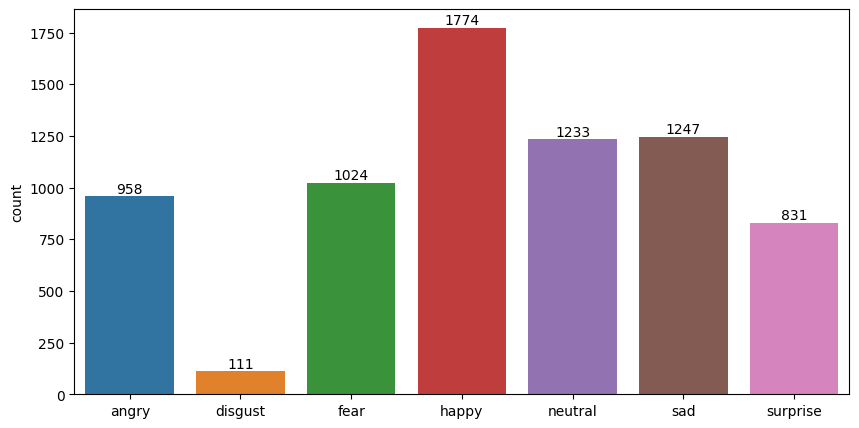

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

test_label_names = [inv_label_map[l] for l in test_labels]

plt.figure(figsize=(10, 5))
ax = sns.countplot(
    x=test_label_names,
    hue=test_label_names,
    palette="tab10"
)

for container in ax.containers:
    ax.bar_label(container)

plt.show()


CNN structure

In [30]:
import torch.nn as nn

model = nn.Sequential(

    nn.Conv2d(1, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(),
    nn.Linear(128*6*6, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 7)
).to(device)

CNN model summary

In [31]:
from torchinfo import summary
summary(model, input_size=(1, 1, 48, 48))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 7]                    --
├─Conv2d: 1-1                            [1, 32, 48, 48]           320
├─ReLU: 1-2                              [1, 32, 48, 48]           --
├─MaxPool2d: 1-3                         [1, 32, 24, 24]           --
├─Conv2d: 1-4                            [1, 64, 24, 24]           18,496
├─ReLU: 1-5                              [1, 64, 24, 24]           --
├─MaxPool2d: 1-6                         [1, 64, 12, 12]           --
├─Conv2d: 1-7                            [1, 128, 12, 12]          73,856
├─ReLU: 1-8                              [1, 128, 12, 12]          --
├─MaxPool2d: 1-9                         [1, 128, 6, 6]            --
├─Flatten: 1-10                          [1, 4608]                 --
├─Linear: 1-11                           [1, 256]                  1,179,904
├─ReLU: 1-12                             [1, 256]                  --

Training CNN

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 30

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Avg Train Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), "emotion_cnn.pth")
print("Model saved")


Epoch 1/30 - Avg Train Loss: 1.6660
Epoch 2/30 - Avg Train Loss: 1.4135
Epoch 3/30 - Avg Train Loss: 1.2856
Epoch 4/30 - Avg Train Loss: 1.1898
Epoch 5/30 - Avg Train Loss: 1.1123
Epoch 6/30 - Avg Train Loss: 1.0478
Epoch 7/30 - Avg Train Loss: 0.9794
Epoch 8/30 - Avg Train Loss: 0.9153
Epoch 9/30 - Avg Train Loss: 0.8468
Epoch 10/30 - Avg Train Loss: 0.7770
Epoch 11/30 - Avg Train Loss: 0.7118
Epoch 12/30 - Avg Train Loss: 0.6545
Epoch 13/30 - Avg Train Loss: 0.5877
Epoch 14/30 - Avg Train Loss: 0.5335
Epoch 15/30 - Avg Train Loss: 0.4845
Epoch 16/30 - Avg Train Loss: 0.4472
Epoch 17/30 - Avg Train Loss: 0.4123
Epoch 18/30 - Avg Train Loss: 0.3828
Epoch 19/30 - Avg Train Loss: 0.3470
Epoch 20/30 - Avg Train Loss: 0.3208
Epoch 21/30 - Avg Train Loss: 0.3010
Epoch 22/30 - Avg Train Loss: 0.2850
Epoch 23/30 - Avg Train Loss: 0.2715
Epoch 24/30 - Avg Train Loss: 0.2491
Epoch 25/30 - Avg Train Loss: 0.2406
Epoch 26/30 - Avg Train Loss: 0.2356
Epoch 27/30 - Avg Train Loss: 0.2253
Epoch 28/3

Test accuracy and confusion matrix

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

model.load_state_dict(torch.load("emotion_cnn.pth", map_location=device))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())

acc = np.mean(np.array(y_true) == np.array(y_pred))
print("Test Accuracy:", acc)

conf_mat = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(conf_mat, index=emotions, columns=emotions)

print("\nConfusion Matrix:\n", cm_df)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=emotions))


Test Accuracy: 0.5880468096962942

Confusion Matrix:
           angry  disgust  fear  happy  neutral  sad  surprise
angry       476        2   101     84      145  116        34
disgust      27       56     8      4        6    7         3
fear        118        2   420     69      161  163        91
happy        62        1    44   1451      128   54        34
neutral      94        2    75    146      742  149        25
sad         151        3   157    137      305  465        29
surprise     37        1    73     50       48   11       611

Classification Report:
               precision    recall  f1-score   support

       angry       0.49      0.50      0.50       958
     disgust       0.84      0.50      0.63       111
        fear       0.48      0.41      0.44      1024
       happy       0.75      0.82      0.78      1774
     neutral       0.48      0.60      0.54      1233
         sad       0.48      0.37      0.42      1247
    surprise       0.74      0.74      0.74   

Downloading the pretrained Yolov8n model

In [34]:
import urllib.request

url = "https://github.com/YapaLab/yolo-face/releases/download/v0.0.0/yolov8n-face.pt"
urllib.request.urlretrieve(url, "yolov8n-face.pt")
print("YOLO model downloaded")


YOLO model downloaded


Loading YOLO model

In [35]:
from ultralytics import YOLO
face_model = YOLO("yolov8n-face.pt")


Detecting faces using YOLO

In [36]:
def detect_faces(frame, conf, iou):
    results = face_model(frame, conf=conf, iou=iou, verbose=False)
    boxes = []

    for r in results:
        if r.boxes is not None:
            for b in r.boxes:
                x1, y1, x2, y2 = b.xyxy[0].cpu().numpy().astype(int)
                c = float(b.conf[0].cpu().numpy())
                boxes.append((x1, y1, x2, y2, c))

    return boxes


Emotion prediction

In [37]:
import cv2

def predict_emotion(face_img):
    face = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
    face = cv2.resize(face, (48, 48))
    face = (face / 255.0 - 0.5) / 0.5

    tensor = torch.tensor(face).unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        out = model(tensor)
        pred = torch.argmax(out).item()

    return inv_label_map[pred]

Real time webcam demo

In [38]:
def run_webcam(conf, iou):
    cap = cv2.VideoCapture(0)
    print("Press 'q' to quit")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        boxes = detect_faces(frame, conf, iou)

        for (x1, y1, x2, y2, conf_score) in boxes:
            face = frame[y1:y2, x1:x2]
            if face.size == 0:
                continue

            emotion = predict_emotion(face)

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            text = f"{emotion} ({conf_score:.2f})"
            cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        cv2.imshow("YOLO Facial Emotion Recognition", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


Starting webcam

In [56]:
run_webcam(conf=0.4, iou=0.5)


Press 'q' to quit


Experiment and evaluation

In [40]:
import time

def run_experiment(conf, iou, duration=6):
    cap = cv2.VideoCapture(0)

    total_frames = 0
    detected_frames = 0
    conf_scores = []
    emotion_preds = []

    start_time = time.time()

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        total_frames += 1
        
        boxes = detect_faces(frame, conf, iou)

        if boxes:  
            detected_frames += 1

            x1, y1, x2, y2, c = boxes[0]
            conf_scores.append(c)

            face = frame[y1:y2, x1:x2]
            if face.size > 0:
                emotion = predict_emotion(face)
                emotion_preds.append(emotion)

            # Draw
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(frame, f"{emotion} ({c:.2f})", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

        cv2.imshow("Experiment", frame)
        cv2.waitKey(1)

        if time.time() - start_time >= duration:
            break

    end_time = time.time()
    cap.release()
    cv2.destroyAllWindows()

    detection_rate = detected_frames / total_frames if total_frames > 0 else 0

    avg_confScore = np.mean(conf_scores) if conf_scores else 0

    if emotion_preds:
        most_common = max(set(emotion_preds), key=emotion_preds.count)
        consistency = emotion_preds.count(most_common) / len(emotion_preds)
    else:
        consistency = 0

    return [conf, iou, detection_rate, avg_confScore, consistency]


Experiments

In [43]:
experiment_pairs = [
    (0.2, 0.3), (0.3, 0.3), (0.4, 0.3), (0.5, 0.3),
    (0.2, 0.5), (0.3, 0.5), (0.4, 0.5), (0.5, 0.5),
    (0.6, 0.4), (0.7, 0.6)
]

results = []

for conf, iou in experiment_pairs:
    print(f"Running: conf={conf}, IoU={iou}")
    r = run_experiment(conf, iou, duration=6)
    results.append(r)

df_results = pd.DataFrame(
    results,
    columns=["Confidence", "IoU", "Detection Rate", "Avg Confidence Score", "Emotion Consistency"]
)

df_results


Running: conf=0.2, IoU=0.3
Running: conf=0.3, IoU=0.3
Running: conf=0.4, IoU=0.3
Running: conf=0.5, IoU=0.3
Running: conf=0.2, IoU=0.5
Running: conf=0.3, IoU=0.5
Running: conf=0.4, IoU=0.5
Running: conf=0.5, IoU=0.5
Running: conf=0.6, IoU=0.4
Running: conf=0.7, IoU=0.6


,Confidence,IoU,Detection Rate,Avg Confidence Score,Emotion Consistency
0,0.2,0.3,1.000000,0.719375,0.433333
1,0.3,0.3,1.000000,0.745278,0.321429
2,0.4,0.3,1.000000,0.724308,0.316667
3,0.5,0.3,1.000000,0.730794,0.396552
4,0.2,0.5,0.983871,0.708705,0.442623
5,0.3,0.5,1.000000,0.743570,0.622951
6,0.4,0.5,1.000000,0.718590,0.966667
7,0.5,0.5,1.000000,0.741094,0.590164
8,0.6,0.4,1.000000,0.745687,0.967742
9,0.7,0.6,0.885246,0.745803,0.425926


Ploting experiment performance

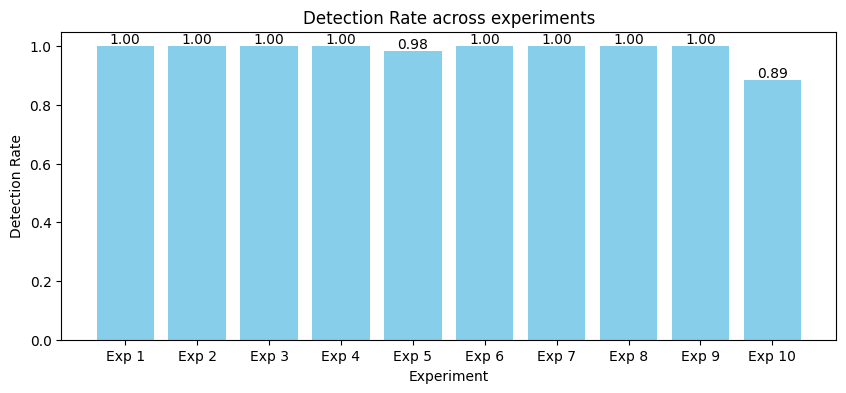

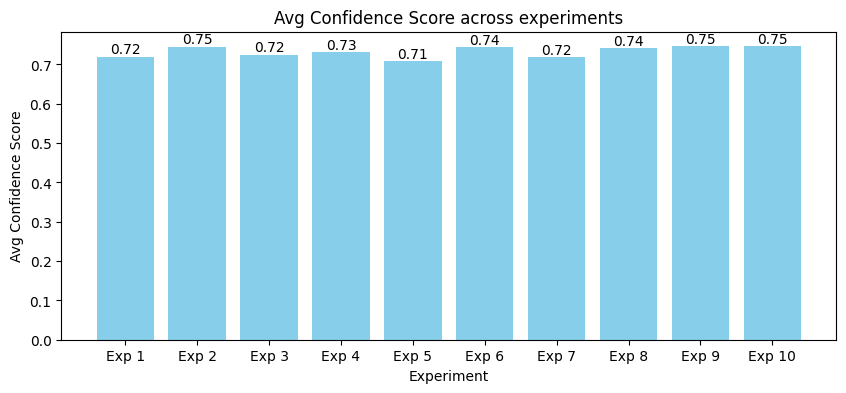

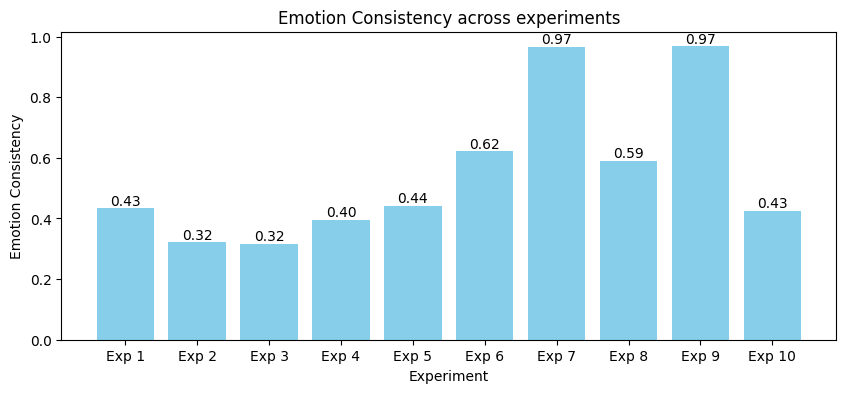

In [44]:
import matplotlib.pyplot as plt

metrics = ["Detection Rate", "Avg Confidence Score", "Emotion Consistency"]

for metric in metrics:
    plt.figure(figsize=(10,4))
    plt.bar(range(len(df_results)), df_results[metric], color="skyblue")
    plt.xticks(range(len(df_results)), [f"Exp {i+1}" for i in range(len(df_results))])
    plt.title(metric + " across experiments")
    plt.xlabel("Experiment")
    plt.ylabel(metric)

    for i, v in enumerate(df_results[metric]):
        plt.text(i, v, f"{v:.2f}", ha='center', va='bottom')

    plt.show()


References

https://www.kaggle.com/datasets/msambare/fer2013
https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html
https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/
https://docs.pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
https://www.geeksforgeeks.org/machine-learning/compute-classification-report-and-confusion-matrix-in-python/
https://github.com/YapaLab/yolo-face/releases/tag/v0.0.0
https://docs.ultralytics.com/modes/predict/#boxes
https://docs.ultralytics.com/modes/predict/
https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga07d2f74cadcf8e305e810ce8eed13bc9
https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html